In [8]:
import pandas as pd
#from binance.spot import Spot as Client
from binance.client import Client
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import ta

In [69]:
import algo.calculate

In [10]:
import importlib, data.read
importlib.reload(data.read)
importlib.reload(algo.calculate)

<module 'algo.calculate' from '/home/junlim/projects/kristjan_swing/algo/calculate.py'>

### backtest algo

In [23]:
importlib.reload(algo.calculate)

<module 'algo.calculate_short' from '/home/junlim/projects/kristjan_swing/algo/calculate_short.py'>

In [12]:
def strategy_backtest(data, portfolio_value, risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase):
    trades = pd.DataFrame(columns=['Asset', 'Entry Date', 'Exit Date', 'Entry Price', 'Exit Price', 'Dollar Return', 'Outcome'])
    open_trades = pd.DataFrame(columns=['Asset', 'Entry Date', 'Entry Price', 'Current Price', 'Stop Loss', 'Potential Dollar Return'])
    for asset, df in data.items():
        df, new_trades, new_open_trades = algo.calculate.trade_asset(asset, df, float(portfolio_value / len(data)), risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase)
        trades = pd.concat([trades, new_trades], ignore_index=True)
        open_trades = pd.concat([open_trades, new_open_trades], ignore_index=True)

    return trades, open_trades

In [13]:
def describe_backtest(data_dict, trades, open_trades, portfolio_value):
    # Sort trades DataFrame by 'Entry Date'
    trades.sort_values(by='Entry Date', inplace=True)
    # Create a figure for individual portfolio plots
    plt.figure(figsize=(12, 8))
    
    # Configure the individual portfolio plot
    plt.title('Individual Portfolio Performance by Asset')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    
    # Initialize a DataFrame to store aligned portfolio values for all assets
    all_portfolios = pd.DataFrame()
    
    # Plot portfolio value for each asset and align for average	calculation
    for asset, df in data_dict.items():
        # no trading happened
        if df['portfolio'].iloc[-1] == df['portfolio'].iloc[0]:
            continue
        plt.plot(df['date'], df['portfolio'], label=f'{asset}')
        all_portfolios[asset] = df.set_index('date')['portfolio'] - portfolio_value

    #all_portfolios.fillna(float(portfolio_value / len(data_dict)), inplace=True)
    all_portfolios.fillna(method='ffill', inplace=True)
    
    plt.legend()
    plt.grid(True)
    plt.show() # Show the plot for individual portfolios
    
    # Create a new figure for the average portfolio plot
    plt.figure(figsize=(12, 8))
    # Calculate the average portfolio value
    all_portfolios['Average Portfolio'] = all_portfolios.sum(axis=1)
    # Plot the average portfolio value
    plt.plot(all_portfolios.index, all_portfolios['Average Portfolio'], label='Average Portfolio', color='black', linewidth=2)
    
    # Configure the average portfolio plot
    plt.title('Average Portfolio Performance')
    plt.xlabel('Date')
    plt.ylabel('Average Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return all_portfolios

### load the cached data

In [14]:
import pickle
data_dict = pickle.load(open('data/data.pickle', 'rb'))

### backtest

In [44]:
importlib.reload(algo.calculate)
importlib.reload(algo.calculate_short)

<module 'algo.calculate_short' from '/home/junlim/projects/kristjan_swing/algo/calculate_short.py'>

In [45]:
# Initial value of the trading portfolio in dollars
portfolio_value = 100000
# Maximum percentage of the portfolio value to risk on a single trade
risk_trade_percentage = 1
# Minimum number of days for an asset to be considered in a consolidation period
min_days_in_consolidation = 7
# Maximum number of days for an asset to remain in the consolidation period
max_days_in_consolidation = 56
# Minimum percentage increase in asset price to consider for trading
min_perc_increase = 30

In [50]:
# Perform backtest of the trading strategy with the fetched data
closed_trades, open_trades = strategy_backtest(data_dict, portfolio_value, risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase)

In [51]:
closed_trades

,Asset,Entry Date,Exit Date,Entry Price,Exit Price,Dollar Return,Outcome
0,BTCUSDT,2019-04-22 20:00:00,2019-04-24 20:00:00,5422.000,5332.410,-298.975130,Stop Loss
1,BTCUSDT,2020-08-16 20:00:00,2020-08-18 20:00:00,12123.460,11769.780,-224.028021,Stop Loss
2,BTCUSDT,2020-12-15 19:00:00,2021-01-19 19:00:00,19888.000,35468.230,2286.634053,Trail
3,BTCUSDT,2021-03-12 19:00:00,2021-03-14 20:00:00,58352.800,56078.230,-487.338973,Stop Loss
4,BTCUSDT,2021-04-09 20:00:00,2021-04-17 20:00:00,60200.000,57900.010,-368.861710,Stop Loss
...,...,...,...,...,...,...,...
84,ATOMUSDT,2019-12-25 19:00:00,2019-12-28 19:00:00,4.555,4.258,-373.953665,Stop Loss
85,ATOMUSDT,2020-08-08 20:00:00,2020-09-01 20:00:00,4.520,6.643,2212.950470,Trail
86,ATOMUSDT,2023-12-05 19:00:00,2023-12-06 19:00:00,10.223,9.700,-480.390619,Stop Loss
87,INJUSDT,2023-03-31 20:00:00,2023-04-22 20:00:00,4.998,6.882,1302.995688,Trail


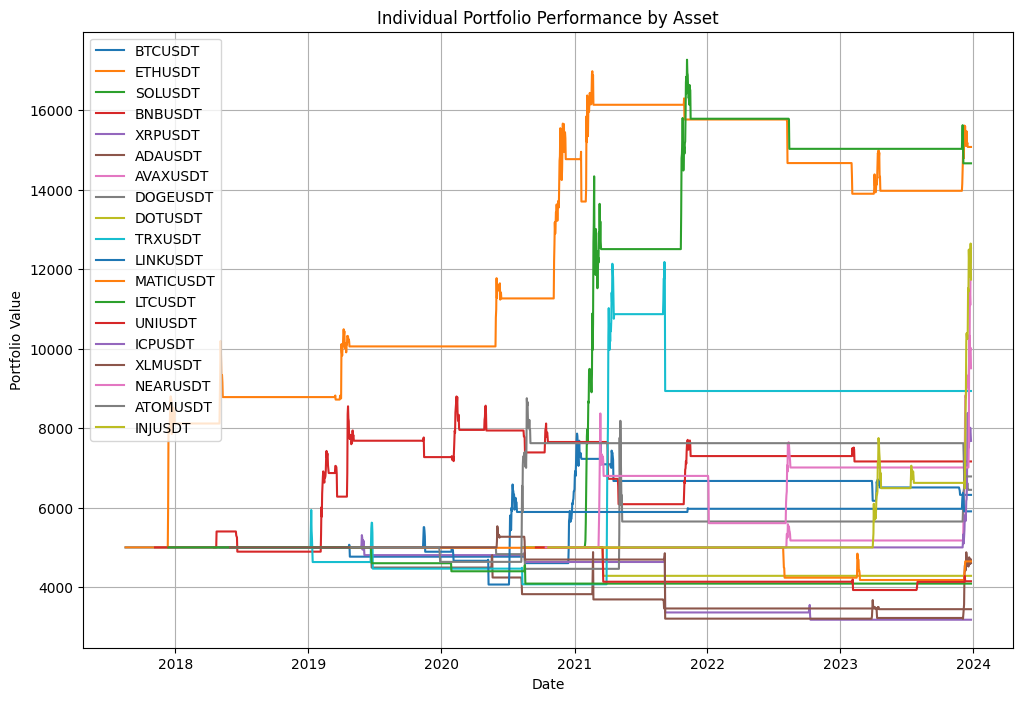

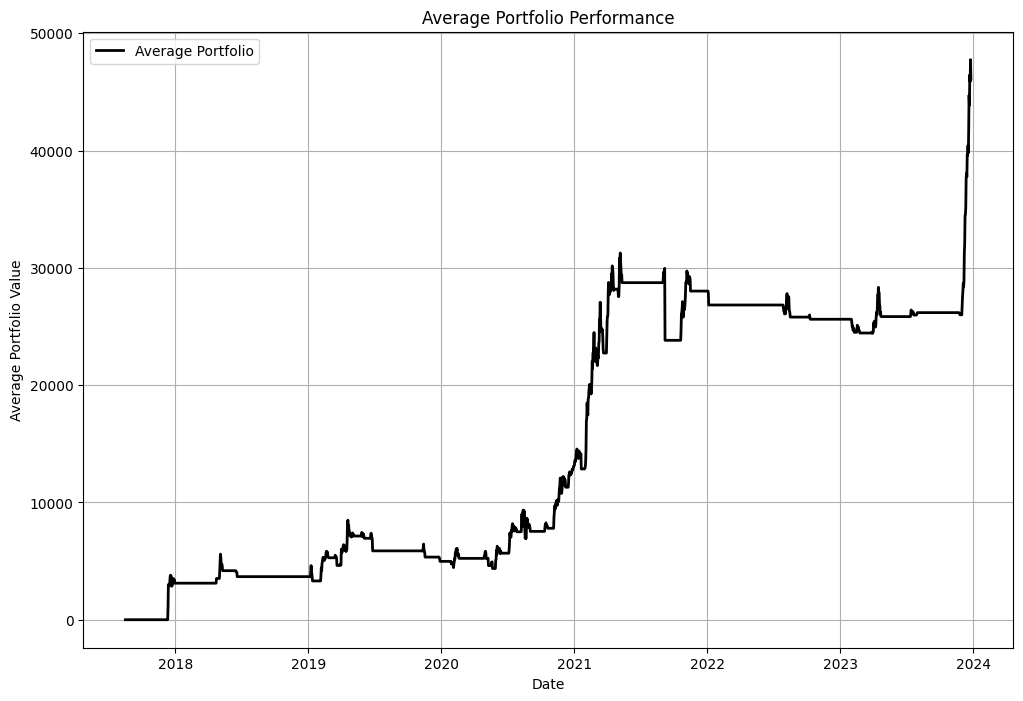

In [52]:
all_portfolios = describe_backtest(data_dict, closed_trades, open_trades, float(portfolio_value / len(data_dict)))